## Co-registration with eFOLKI example code

This code loads a hyperspectral image in ENVI format (with header file) extracts matching wavelength then calculates optical flow

Option for applying the transformation to every band and storing in new array

__Before using make sure to git clone _https://github.com/aplyer/gefolki.git___


[eFOLKI parameters](#16) should be adjusted based on your input imagery

For more information please see original github repository at _https://github.com/aplyer/gefolki.git_

If using please reference original authors:

>eFOLKI:
>
> _Aurélien Plyer, Elise Colin-Koeniguer, Flora Weissgerber, "A New Coregistration Algorithm for Recent Applications on Urban SAR Images", Geoscience and Remote Sensing Letters, IEEE , vol.12, no.11, pp. 2198 – 2202, nov 2015_
>
> _Plyer, A., Le Besnerais, G., & Champagnat, F. (2016). Massively parallel Lucas Kanade optical flow for real-time video processing applications. Journal of Real-Time Image Processing, 11(4), 713-730._

>GeFOLKI:
>
> _Guillaume Brigot, Elise Colin-Koeniguer, Aurélien Plyer, Fabrice Janez, "Adaptation and Evaluation of an Optical Flow Method Applied to Coregistration of Forest Remote Sensing Images", IEEE Journal of Selected Topics in Applied Earth Observations ans Remote Sensing, Volume 9, Issue 7, July 2016_

In [10]:
# Import statements
import numpy as np
import pylab as pl
import spectral.io.envi as envi
import time
import sys
sys.path.append('gefolki/python')
from algorithm import EFolki
from tools import wrapData

### Set toggles
>Base band refers to band in base image (such as RGB image)


In [11]:
## Toggles ##
Base_band = 0
Moving_band = 58


### Set directories and load imagery
>Using spectral.io.envi it will load using the header file


In [12]:
## Directories ##
base_image = r"path_to_your_base_image.hdr"

moving_image = r"path_to_your_moving_image.hdr"

In [13]:
## Load imagery function ##
def ENVI_load_image(file):
    master = envi.open(file)
    im = master[:, :, :]
    return im

### Import imagery, extract and plot single bands

>If imagery is not in ENVI format, can be loaded as a TIF file using imread function from skimage and convert to greyscale using rgb2gray function

Text(0.5, 1.0, 'Moving image')

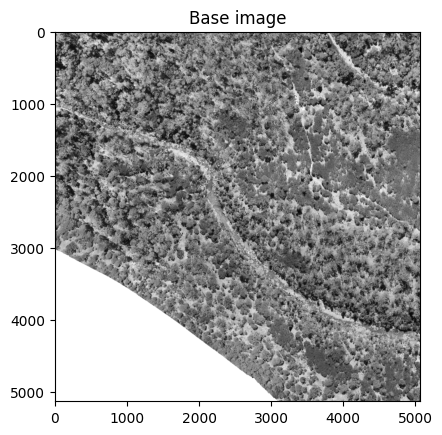

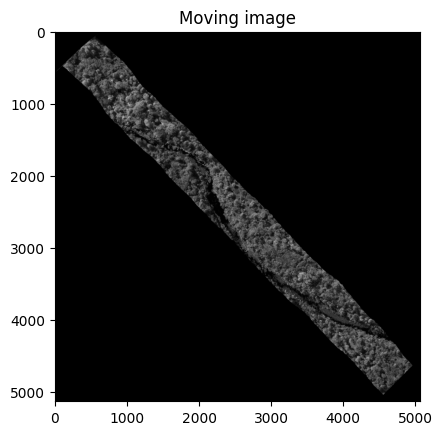

In [14]:
## Import imagery ##
base = ENVI_load_image(base_image)
moving = ENVI_load_image(moving_image)
base_singleband = base[:,:,Base_band]
moving_singleband = moving[:, :, Moving_band]

pl.figure()
pl.imshow(base_singleband, cmap='gray')
pl.title('Base image')

pl.figure()
pl.imshow(moving_singleband, cmap='gray')
pl.title('Moving image')

### Mask if necessary

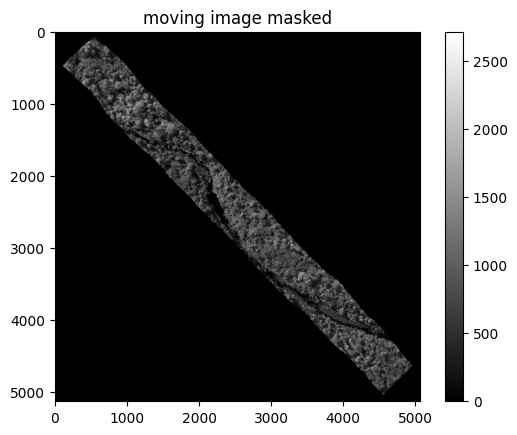

In [15]:
## Mask moving image ##

mask = base_singleband > 0.0
base_singleband = base_singleband * mask
moving_singleband = moving_singleband * mask

pl.figure()
pl.imshow(moving_singleband, cmap='gray')
pl.title('moving image masked')
pl.colorbar()

## Calculate optical flow using eFOLKI

>Uses input parameters (iteration, radius, rank, and levels)
>These parameters should be adjusted based on your input imagery and requirements

>Plots norm of registration
<a id="16"></a>

Calculating flow... 

It took 7.473 minutes to calculate flow 



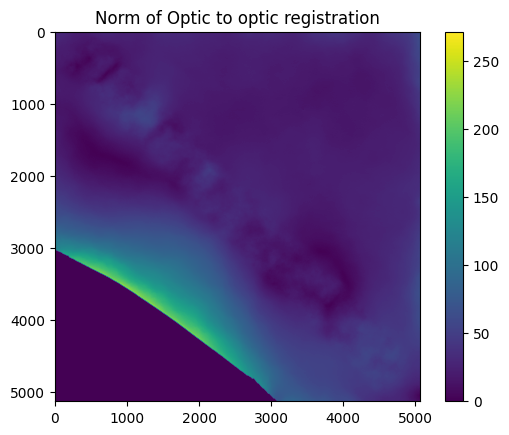

In [17]:
## Calculate optical flow ##
print("Calculating flow... \n")
t0 = time.perf_counter()
u, v = EFolki(base_singleband, moving_singleband, iteration=8, radius=[16, 8 , 4], rank=4, levels=6)
t1 = time.perf_counter()
tdiff = (t1 - t0) /60
print("It took %.3f minutes to calculate flow \n" % (tdiff))

#plot norm of flow
N = np.sqrt(u**2+v**2)

pl.figure()
pl.imshow(N)
pl.title('Norm of Optic to optic registration')
pl.colorbar()

## Register image using optical flow
>Warps the data using deoformation field created using eFOLKI

Registering image... 



Text(0.5, 1.0, 'Registered image')

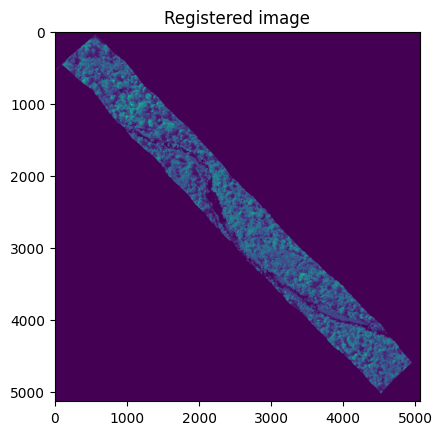

In [18]:
## Register image ##
print("Registering image... \n")
imag_reg = wrapData(moving_singleband, u, v)

pl.figure()
pl.imshow(imag_reg)
pl.title('Registered image')

## Apply transform to all bands in array
>Applies warp to all bands in the array using a simple FOR loop

>Stores in new array (processed_array)

>Can then be exported as desired


In [ ]:
### Example code to apply transformation to each band and store in new array ###

# Apply mask to every band in original array
expanded_mask = np.expand_dims(mask, axis=2)
moving = moving * expanded_mask

# Pre-allocate the output array with the same shape
processed_array = np.empty_like(moving)

t0 = time.perf_counter()
# Loop through each band and apply the transform
for band in range(moving.shape[2]):
    print(f"Processing each band...")
    im = moving[:, :, band]
    # Apply the warp to the individual band
    im_warped = wrapData(im, u, v)
    # Store the processed band in the new array
    processed_array[:, :, band] = im_warped

# time check
t1 = time.perf_counter()
tdiff = (t1 - t0) /60
print("It took %.3f minutes to apply transform to all bands and store in new array\n" % (tdiff))